In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

full_data_path = '/workspaces/Health-Indicators/notebooks/diabetes_012_health_indicators_BRFSS2015.csv'
df_full = pd.read_csv(full_data_path)
print(df_full.isnull().sum())


/tmp/ipykernel_2050/1110335023.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [2]:
# Select features for the prediction model
features_to_use = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                   'PhysActivity', 'DiffWalk', 'Sex', 'Age',]  
X = df_full[features_to_use]
y = df_full['Diabetes_012']


In [3]:
# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)


In [5]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Import XGBoost and train the model
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Predict probabilities for the test set
y_pred_xgb_proba = xgb.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
n_classes = y_pred_xgb_proba.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_xgb_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate ROC AUC for each class and convert to percentage
roc_auc_percentages = {i: auc * 100 for i, auc in roc_auc.items()}
print("ROC AUC scores as percentages:")
for class_id, roc_auc_percentage in roc_auc_percentages.items():
    print(f"Class {class_id}: {roc_auc_percentage:.2f}%")

# This code calculates the ROC AUC score for each class and converts the score to a percentage.
# This representation as a percentage might be more intuitive and helps in understanding the model's performance more clearly.  



ROC AUC scores as percentages:
Class 0: 92.97%
Class 1: 93.54%
Class 2: 85.47%


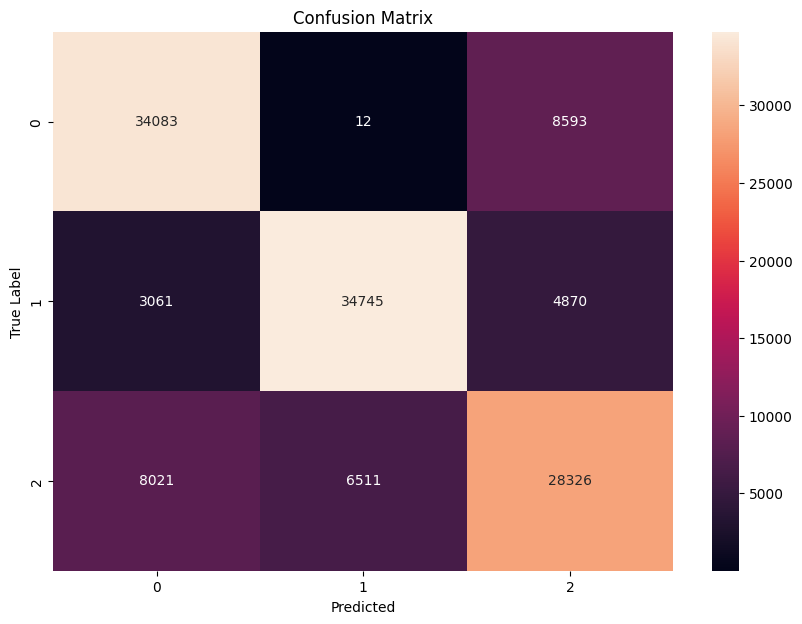

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_xgb = xgb.predict(X_test_scaled)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# The confusion matrix is a performance measurement for machine learning classification.
# It is extremely useful for measuring Recall, Precision, Specificity, Accuracy and most importantly AUC-ROC Curve.
# In this matrix, the X-axis represents the predicted classifications and the Y-axis represents the true classifications.
# Each cell in the grid represents the count of true positives, false negatives, true negatives, and false positives.

- **True Negatives (TN):** The top-left square (34,083) indicates the number of correctly predicted negatives for class 0, meaning the cases that were not class 0 and were also not predicted as class 0.
- **False Positives (FP):** The top-middle square (12) shows the number of false positives for class 0, where the model incorrectly predicted the positive class (either class 1 or 2).
- **False Negatives (FN):** The middle-left square (3,061) indicates the false negatives for class 1, where the model incorrectly predicted the negative class (either class 0 or 2).
- **True Positives (TP) for Class 1:** The middle square (34,745) shows the number of true positives for class 1, meaning instances that were class 1 and were correctly predicted as class 1.
- **False Positives for Class 2 as Predicted Class 1:** The middle-right square (4,870) shows the number of instances that were actually class 2 but were predicted as class 1.
- **False Positives for Class 1 as Predicted Class 0:** The bottom-left square (8,021) shows the number of instances that were actually class 1 but were predicted as class 0.
- **True Positives for Class 2:** The bottom-right square (28,326) shows the number of true positives for class 2, meaning instances that were class 2 and were correctly predicted as class 2.
- **False Negatives for Class 2:** The middle-bottom square (6,511) indicates the false negatives for class 2, where instances were class 2 but were incorrectly predicted as class 1.

To relate this problem:
- **TN for class 0** suggests your model is quite good at identifying cases that are not class 0.
- **TP for class 1 and class 2** show how many cases were correctly identified as belonging to their respective classes.
- **FNs for class 1 and class 2** show the cases where the model failed to identify the true class 1 and class 2 instances, respectively.
- **FPs across classes** show where misclassifications happened.


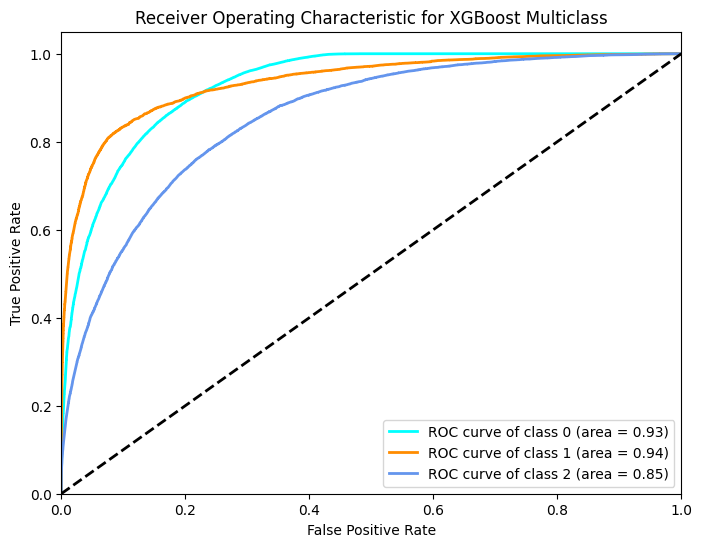

In [9]:
# Plotting ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost Multiclass')
plt.legend(loc="lower right")
plt.show()





In [10]:
from joblib import dump

dump(xgb, "xgboost_diabetes_model.joblib")

['xgboost_diabetes_model.joblib']